# Lasso, Ridge, Elastic-net

In [1]:
import os
os.environ['R_HOME']= "C:/Anaconda3/envs/py38r40/lib/R" ## R.home()

In [2]:
import rpy2
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [5]:
%%R
set.seed(9999)
n<-20000
toeic <- 750 + rnorm(n,sd=80)
toeic[toeic>990] <- 990
toeic <- round(toeic)
teps <- toeic + rnorm(n,sd=0.01)
gpa <- 3.5 + rnorm(n,sd=0.3)
gpa[gpa>4.5] <- 4.5
gpa <- round(gpa,1)
sal <- gpa*600 + toeic*5 + rnorm(n, sd=300)
sal <- round(sal)

### Analysis:

#### [데이터 정리]

In [6]:
%%R
X<-cbind(toeic,teps,gpa)
y<-sal

In [7]:
%%R
head(X)

     toeic     teps gpa
[1,]   837 837.0066 3.1
[2,]   817 816.9809 3.6
[3,]   790 789.9939 3.5
[4,]   688 687.9981 3.6
[5,]   982 981.9988 2.9
[6,]   823 823.0172 3.9


In [8]:
%R -o X,y #R에서 한 데이터 파이썬으로 이동시키기

In [9]:
X,y

(array([[837.        , 837.00659926,   3.1       ],
        [817.        , 816.98090417,   3.6       ],
        [790.        , 789.99388281,   3.5       ],
        ...,
        [828.        , 828.00137839,   3.6       ],
        [782.        , 782.00527482,   3.7       ],
        [822.        , 822.01226229,   2.7       ]]),
 array([5668., 6168., 5966., ..., 6075., 6554., 5893.]))

### [풀이1] Ridge: 해석적풀이

In [10]:
import numpy as np

In [11]:
λ=1
λI=np.diag([λ]*3)
λI

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [12]:
bhat_ridge=np.linalg.inv(X.T@X + λI) @ X.T @y

In [13]:
bhat_ridge

array([-79.208969  ,  84.21375457, 600.83093632])

### [풀이2] Ridge: `sklearn` 패키지 활용

In [14]:
from sklearn.linear_model import Ridge
ridge=Ridge(alpha=1.0) # alpha는 lambda값임
rlst=ridge.fit(X,y)

In [15]:
#dir(rlst)
rlst.coef_

array([-79.42732408,  84.45761006, 609.14106189])

### [풀이3] Lasso: `sklearn`패키지 이용

In [16]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=1.0) # alpha는 lambda값임
rlst=lasso.fit(X,y)
rlst.coef_

array([5.02994425e+00, 5.06370365e-06, 5.98333362e+02])

--> ${\tt teps}$에 해당하는 계수가 0이므로 Lasso에 의해 변수선택이 잘 되었음을 알 수 있다.

희소학습..

### [풀이4] Ridge: `glmnet`패키지 활용

- 변수 표준화를 해줌
- 최적의 $\lambda$값을 찾아줌

From cffi callback <function _consolewrite_ex at 0x000001D19BBFE3A0>:
Traceback (most recent call last):
  File "C:\Anaconda3\envs\py38r40\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Anaconda3\envs\py38r40\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc7 in position 0: invalid continuation byte
R[write to console]: Loaded glmnet 4.1-1



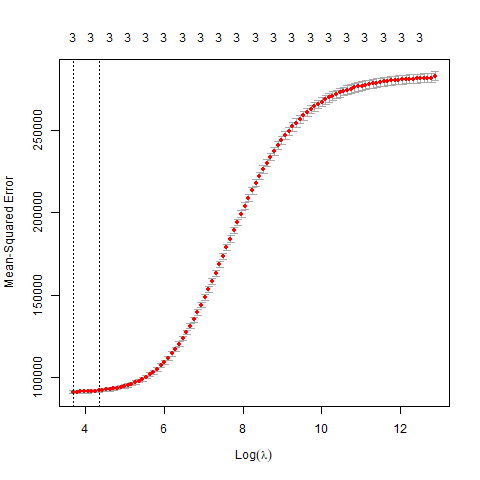

In [17]:
%%R
library(glmnet) #default로 표준화를 해준다. 그래서 편리!!!
cvfit_ridge<-cv.glmnet(X,y,alpha=0) #cv:cross validation, alpha=0 : Ridge
plot(cvfit_ridge)

`cv.glmnet(X,y,alpha=0)`에서
- `alpha=0` : Ridge
- `alpha=1` : Lasso
- `alpha` $\in (0,1)$ : Elastic-net

왼쪽점선: 최적값(교차검증오차의 최소값)

오른쪽점선: 최적이랑 비슷하면서 간단한 모형을 만드는 $\lambda$

In [18]:
%%R
names(cvfit_ridge)

 [1] "lambda"     "cvm"        "cvsd"       "cvup"       "cvlo"      
 [6] "nzero"      "call"       "name"       "glmnet.fit" "lambda.min"
[11] "lambda.1se" "index"     


In [19]:
%%R
print(log(cvfit_ridge$lambda.min))
print(log(cvfit_ridge$lambda.1se))

[1] 3.68502
[1] 4.336256


따라서 람다는

In [20]:
%%R
print(cvfit_ridge$lambda.min)
print(cvfit_ridge$lambda.1se)

[1] 39.84592
[1] 76.42089


In [21]:
%%R
cvfit_ridge #각각의 람다에 따라 다른 beta값이 나오겠지?


Call:  cv.glmnet(x = X, y = y, alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  39.85   100   91006 884.9       3
1se  76.42    93   91881 928.4       3


In [22]:
%%R
print(coef(cvfit_ridge,s='lambda.min'))
print(coef(cvfit_ridge,s='lambda.1se'))

4 x 1 sparse Matrix of class "dgCMatrix"
                     1
(Intercept) 235.939274
toeic         2.434812
teps          2.413922
gpa         566.809663
4 x 1 sparse Matrix of class "dgCMatrix"
                     1
(Intercept) 472.998392
toeic         2.350221
teps          2.342250
gpa         532.575101


두 모형이 모두 그럴듯함.

(i) 토익, 텝스에 대응하는 계수합이 5이어야 하며

(ii) 토익, 텝스의 계수값이 거의 비슷해야하는데

이론적인 탐구내용과 일치함.

[풀이5] Lasso: `glmnet`을 활용

In [23]:
%%R
library(glmnet)
cvfit_lasso<-cv.glmnet(X,y,alpha=1) ## alpha=1 : Lasso
cvfit_lasso


Call:  cv.glmnet(x = X, y = y, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index Measure   SE Nonzero
min  1.983    58   90649 1314       3
1se 24.449    31   91842 1346       3


In [24]:
%%R
print(coef(cvfit_lasso,s='lambda.min'))
print(coef(cvfit_lasso,s='lambda.1se'))

4 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -7.508038e+00
toeic        5.004742e+00
teps         4.435535e-04
gpa          6.028313e+02
4 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) 4.692355e+02
toeic       4.720722e+00
teps        2.299091e-04
gpa         5.275315e+02


## 4월 28일-(1) (중간고사 이후)

# 예제 2

자료 : 야구선수

In [27]:
%%R
#install.packages("ISLR")
library(ISLR)
head(Hitters)

                  AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun
-Andy Allanson      293   66     1   30  29    14     1    293    66      1
-Alan Ashby         315   81     7   24  38    39    14   3449   835     69
-Alvin Davis        479  130    18   66  72    76     3   1624   457     63
-Andre Dawson       496  141    20   65  78    37    11   5628  1575    225
-Andres Galarraga   321   87    10   39  42    30     2    396   101     12
-Alfredo Griffin    594  169     4   74  51    35    11   4408  1133     19
                  CRuns CRBI CWalks League Division PutOuts Assists Errors
-Andy Allanson       30   29     14      A        E     446      33     20
-Alan Ashby         321  414    375      N        W     632      43     10
-Alvin Davis        224  266    263      A        W     880      82     14
-Andre Dawson       828  838    354      N        E     200      11      3
-Andres Galarraga    48   46     33      N        E     805      40      4
-Alfredo Griffin  

목표: $y$를 Salary로 설정하고 나머지를 $X$로 설정하고 회귀분석을 한다.

분석:

단계1: missing이 보이므로 제거

In [28]:
%%R
Hitters<-na.omit(Hitters)
head(Hitters)

                  AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun
-Alan Ashby         315   81     7   24  38    39    14   3449   835     69
-Alvin Davis        479  130    18   66  72    76     3   1624   457     63
-Andre Dawson       496  141    20   65  78    37    11   5628  1575    225
-Andres Galarraga   321   87    10   39  42    30     2    396   101     12
-Alfredo Griffin    594  169     4   74  51    35    11   4408  1133     19
-Al Newman          185   37     1   23   8    21     2    214    42      1
                  CRuns CRBI CWalks League Division PutOuts Assists Errors
-Alan Ashby         321  414    375      N        W     632      43     10
-Alvin Davis        224  266    263      A        W     880      82     14
-Andre Dawson       828  838    354      N        E     200      11      3
-Andres Galarraga    48   46     33      N        E     805      40      4
-Alfredo Griffin    501  336    194      A        W     282     421     25
-Al Newman        

단계2: $X,y$분리

In [30]:
%%R
y<- Hitters$Salary
X<- model.matrix(Salary~., Hitters)

단계3: (1) Lasso

In [33]:
%%R
#library(glmnet)
cvfit_lasso<-cv.glmnet(X,y,alpha=1)

In [37]:
%%R
print(coef(cvfit_lasso,s='lambda.min'))
print(coef(cvfit_lasso,s='lambda.1se'))

21 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept)  129.4155569
(Intercept)    .        
AtBat         -1.6130155
Hits           5.8058915
HmRun          .        
Runs           .        
RBI            .        
Walks          4.8469340
Years         -9.9724045
CAtBat         .        
CHits          .        
CHmRun         0.5374550
CRuns          0.6811938
CRBI           0.3903563
CWalks        -0.5560143
LeagueN       32.4646094
DivisionW   -119.3480842
PutOuts        0.2741895
Assists        0.1855978
Errors        -2.1650837
NewLeagueN     .        
21 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) 144.37970485
(Intercept)   .         
AtBat         .         
Hits          1.36380384
HmRun         .         
Runs          .         
RBI           .         
Walks         1.49731098
Years         .         
CAtBat        .         
CHits         .         
CHmRun        .         
CRuns         0.15275165
CRBI          0.

단계3: (2) Ridge

In [39]:
%%R
cvfit_ridge<-cv.glmnet(X,y,alpha=0)
print(coef(cvfit_ridge,s='lambda.min'))
print(coef(cvfit_ridge,s='lambda.1se'))

21 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  8.112693e+01
(Intercept)  .           
AtBat       -6.815959e-01
Hits         2.772312e+00
HmRun       -1.365680e+00
Runs         1.014826e+00
RBI          7.130225e-01
Walks        3.378558e+00
Years       -9.066800e+00
CAtBat      -1.199478e-03
CHits        1.361029e-01
CHmRun       6.979958e-01
CRuns        2.958896e-01
CRBI         2.570711e-01
CWalks      -2.789666e-01
LeagueN      5.321272e+01
DivisionW   -1.228345e+02
PutOuts      2.638876e-01
Assists      1.698796e-01
Errors      -3.685645e+00
NewLeagueN  -1.810510e+01
21 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) 159.796625704
(Intercept)   .          
AtBat         0.102483884
Hits          0.446840518
HmRun         1.289060569
Runs          0.702915317
RBI           0.686866068
Walks         0.925962427
Years         2.714623467
CAtBat        0.008746278
CHits         0.034359576
CHmRun        0.253594870
CRuns 

단계3: (3) 일레스틱넷

In [40]:
%%R
cvfit_elastic<-cv.glmnet(X,y,alpha=0.3)
print(coef(cvfit_elastic,s='lambda.min'))
print(coef(cvfit_elastic,s='lambda.1se'))

21 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  1.107398e+02
(Intercept)  .           
AtBat       -1.217685e+00
Hits         4.740325e+00
HmRun        .           
Runs         .           
RBI          4.483625e-02
Walks        4.398013e+00
Years       -1.008495e+01
CAtBat       .           
CHits        8.204711e-02
CHmRun       6.603399e-01
CRuns        4.804831e-01
CRBI         3.135958e-01
CWalks      -4.387955e-01
LeagueN      3.271547e+01
DivisionW   -1.228382e+02
PutOuts      2.685147e-01
Assists      1.682786e-01
Errors      -2.638081e+00
NewLeagueN  -2.670575e-03
21 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) 1.831780e+02
(Intercept) .           
AtBat       .           
Hits        7.163805e-01
HmRun       .           
Runs        5.163958e-01
RBI         5.647107e-01
Walks       1.257039e+00
Years       .           
CAtBat      3.921596e-03
CHits       4.910562e-02
CHmRun      2.685659e-01
CRuns       1.18253

Lasso의 결과에 비해서는 합리적인 해석을 줄 수가 있다.

alpha를 결정해야하는데 training/test set으로 나누어서 예측을 잘하는 그런애들로 뽑으면 된다.

---
## Next : Logistic Regression